In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt # библиотека визуализации

#для парсинга данных
import requests # Импортируем библиотеку requests
from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup


In [66]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [68]:
data = pd.read_csv('hotels.csv')
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


- hotel_address - адрес отеля
- additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- review_date - дата, когда рецензент разместил соответствующий отзыв.
- average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
- hotel_name - название отеля
- reviewer_nationality - национальность рецензента
- negative_review - отрицательный отзыв, который рецензент дал отелю.
- review_total_negative_word_counts - общее количество слов в отрицательном отзыв
- positive_review - положительный отзыв, который рецензент дал отелю
- review_total_positive_word_counts - общее количество слов в положительном отзыве
- reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
- total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
- total_number_of_reviews - общее количество действительных отзывов об отеле
- tags - теги, которые рецензент дал отелю.
- days_since_review - продолжительность между датой проверки и датой очистки
- lat - широта отеля
- lng - долгота отеля

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

## Признак tags

In [70]:
#обработаем признак tags, разделив текст на список значений и создадим словарь, где посчитаем количество указанных тегов
def tegs (list):
        list = list.replace('[', '').replace(']', '').replace("'", '')
        tegs = list.split(',')
        for i in range(len(tegs)):
            tegs[i] = tegs[i].strip()
            if tegs[i] in list_tegs.keys():
                list_tegs[tegs[i]]+=1
            else:
                list_tegs[tegs[i]]=1
        return tegs
list_tegs = {}
data['tags'] = data['tags'].apply(tegs)


In [71]:
#Из полученного словаря создадим DataFrame и выведем 20 максимальных значений
df_tegs = pd.DataFrame.from_dict(list_tegs, orient = 'index')
display(f'Всего записей в общей таблице: {data.shape[0]}')
display(f'Количество встречающихся тегов: {df_tegs.shape[0]}')
display(f'Количество всех проставленных тегов: {df_tegs[0].sum()}')
display(df_tegs[0].sort_values().nlargest(20))

'Всего записей в общей таблице: 386803'

'Количество встречающихся тегов: 2368'

'Количество всех проставленных тегов: 1767522'

Leisure trip                      313593
Submitted from a mobile device    230778
Couple                            189212
Stayed 1 night                    145373
Stayed 2 nights                   100263
Solo traveler                      81235
Stayed 3 nights                    72000
Business trip                      61989
Group                              49088
Family with young children         45836
Stayed 4 nights                    35748
Double Room                        26386
Standard Double Room               24151
Superior Double Room               23550
Family with older children         19802
Deluxe Double Room                 18623
Double or Twin Room                16824
Stayed 5 nights                    15611
Standard Double or Twin Room       13062
Classic Double Room                12716
Name: 0, dtype: int64

**Проанализируем полученные результаты**
Из 20 наиболее встречающихся тегов, реже всего отмечали *'Classic Double Room'*. Этот тег отмечен *12716*, что составляет чуть больше 3% от всех записей и менее 1% от всех указанных тегов, а значит теги, не попавшие в 20-ку не сильно повлияют на обучение модели и иих можно исключить из анализа.
**Проанализируем полученные теги**
Чаще всего встречаются теги указывающие на тип поездки (Leisure или Business), на количество проживающих (Couple, Solo и т.д.), на количество проведённых ночей (от 1 до 5) и на тип комнаты. Так же в выборку попал тег 'Submitted from a mobile device', его так же стоит выделить в отдельный признак. 

In [72]:
#для удобства, 20 наиболее встречающихся тегов в виде списка, а затем удалим из него обработанные знаечния 
list_teg_larg = list(df_tegs[0].sort_values().nlargest(20).index)
print (list_teg_larg)

#создадим функцию, которая будет удалять их списка тегов те, которые мы уже отработали
def del_list (mylist, list_remove):
    for i in list_remove:
        mylist.remove(i)
    return mylist    

['Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip', 'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room', 'Standard Double Room', 'Superior Double Room', 'Family with older children', 'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights', 'Standard Double or Twin Room', 'Classic Double Room']


'Пропущенных значений = 0.0'

{'web': 'https://www.comet.com/api/image/download?imageId=8008353770b54d15b4dc414aaf64b72a&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8008353770b54d15b4dc414aaf64b72a&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '8008353770b54d15b4dc414aaf64b72a'}

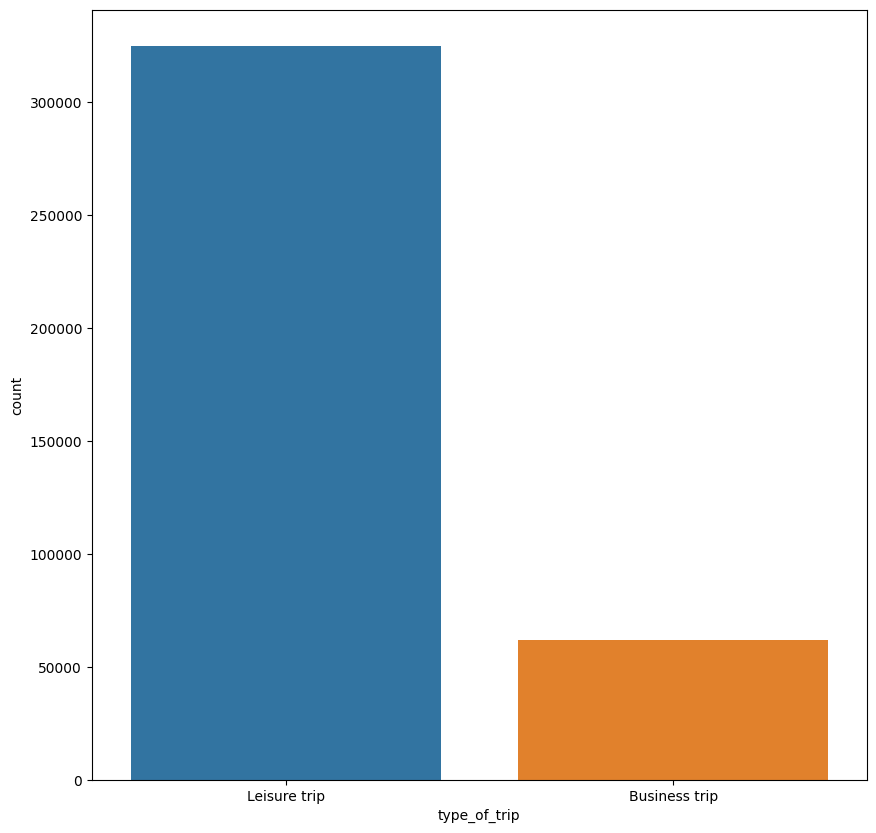

In [73]:
#Выделим признак типа поездки
def type_of_trip (list):
    for i in list:
        if i in list_trip:
            return i
    #так как чаще всего встречаются поездки Leisure, то будем указывать их, если пользователь не указал тип поездки        
    return 'Leisure trip'

#определим список с наиболее встречающимися значениями типа поездки и свормируем новый признак на его основе
list_trip = ['Leisure trip', 'Business trip'] 
data['type_of_trip'] = data['tags'].apply(type_of_trip)
#Проверим полученные результаты
display(f"Пропущенных значений = {data['type_of_trip'].isnull().mean() * 100}")

#визуализируем полученные данные
sns.countplot(x='type_of_trip', data=data);


#удалим из списка теги с типом поездки
list_teg_larg = del_list (list_teg_larg, list_trip)

experiment.log_figure(figure=plt)

{'web': 'https://www.comet.com/api/image/download?imageId=c0fa7017633d402b8e5b1d89645ca388&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c0fa7017633d402b8e5b1d89645ca388&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'c0fa7017633d402b8e5b1d89645ca388'}

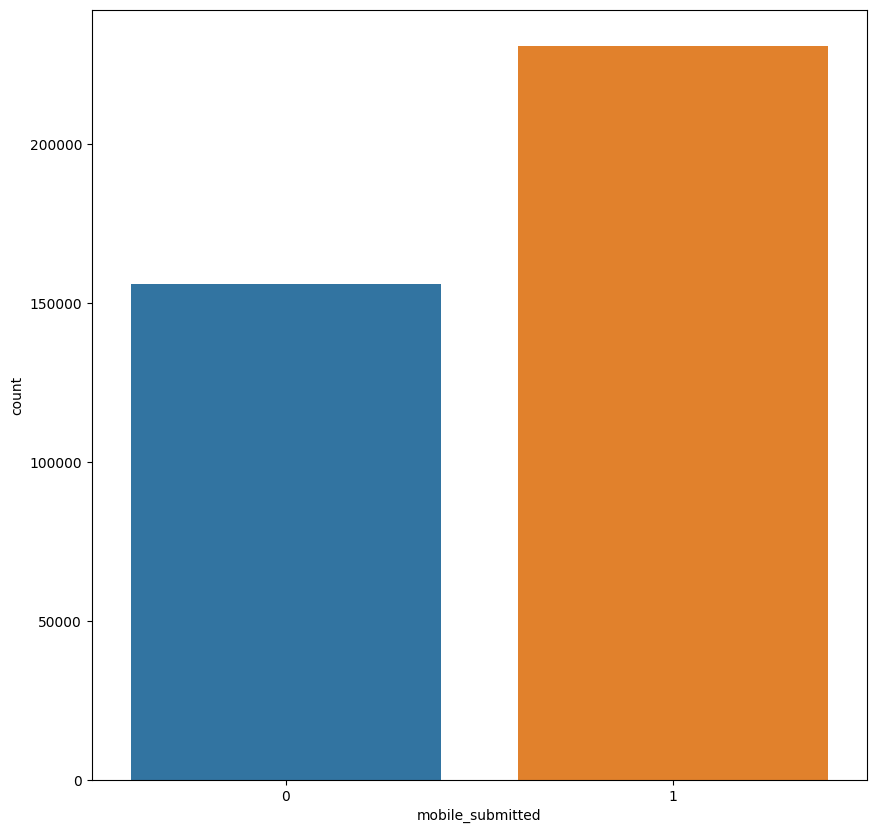

In [74]:
#Создадим признак отвечающий за тег 'Submitted from a mobile device'
data['mobile_submitted'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

#визуализируем полученные данные
sns.countplot(x='mobile_submitted', data=data);

#удалим из списка тег 'Submitted from a mobile device'
list_teg_larg.remove('Submitted from a mobile device')

experiment.log_figure(figure=plt)

'Пропущенных значений = 0.0'

{'web': 'https://www.comet.com/api/image/download?imageId=b523e755ed2e4cc88d681be80e5d29f2&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b523e755ed2e4cc88d681be80e5d29f2&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'b523e755ed2e4cc88d681be80e5d29f2'}

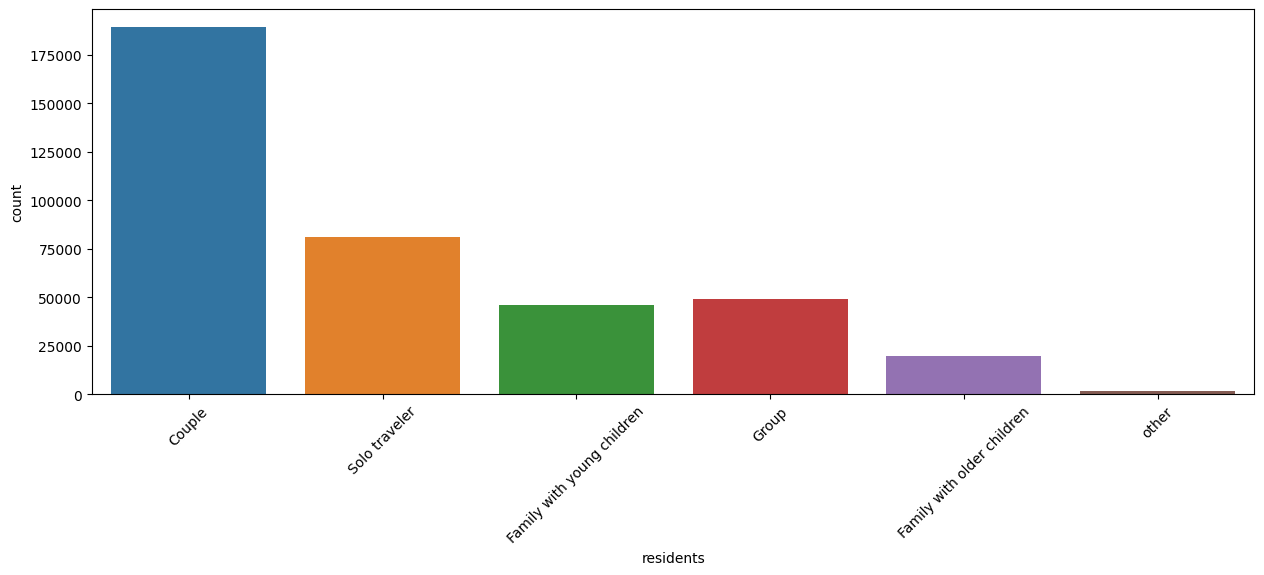

In [75]:
#Выделим признак количества проживающих
def number_of_residents (list):
    for i in list:
        if i in list_residents:
            return i
    #Если не встретилось ни одно значение, то возвращаем other
    return 'other'

#определим список с наиболее встречающимися значениями количества проживающих
list_residents = ['Couple', 'Solo traveler',  'Group', 'Family with young children', 'Family with older children'] 
data['residents'] = data['tags'].apply(number_of_residents)

#Проверим полученные результаты
display(f"Пропущенных значений = {data['residents'].isnull().mean() * 100}")

#визуализируем полученные данные

plt.figure(figsize = (15,5))
ax = sns.countplot(x='residents', data=data);
plt.xticks(rotation=45)

#удалим из списка теги с типом поездки
list_teg_larg = del_list (list_teg_larg, list_residents)

experiment.log_figure(figure=plt)

Как мы и предполагали, процент проживающих в отеле в другой компании мал, поэтмоу объединение не сильно повлияет на результаты

'Пропущенных значений = 0.0'

{'web': 'https://www.comet.com/api/image/download?imageId=02591e4d70f34e6fa5cb9f8b03502a2b&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=02591e4d70f34e6fa5cb9f8b03502a2b&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '02591e4d70f34e6fa5cb9f8b03502a2b'}

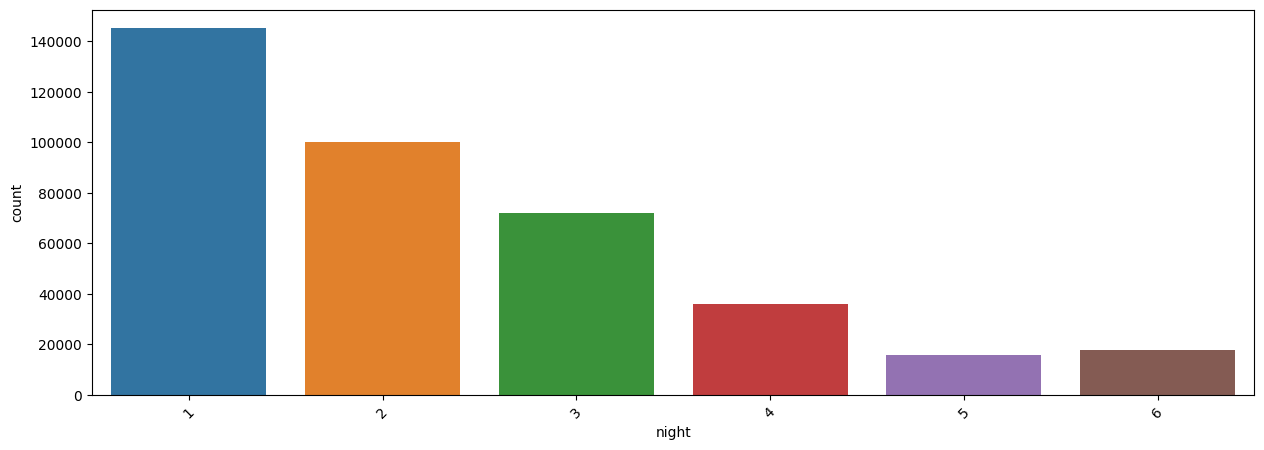

In [76]:
#Выделим признак количества проведённых в отеле ночей
def nights (list):
    for i in list:
        if i in list_night.keys():
            return list_night [i]
    #если попадается значение не встречающееся в списке, то это зачастую большее количество ночей. Для таких строк мы присвоим значение 6
    return 6

#определим список с наиболее встречающимися значениями количества ночей
list_night = {'Stayed 1 night':1, 'Stayed 2 nights':2, 'Stayed 3 nights':3, 'Stayed 4 nights':4, 'Stayed 5 nights':5}
data['night'] =  data['tags'].apply(nights)

#Проверим полученные результаты
display(f"Пропущенных значений = {data['night'].isnull().mean() * 100}")

#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='night', data=data);
plt.xticks(rotation=45);

#удалим из списка теги с количеством ночей
list_teg_larg = del_list (list_teg_larg, list_night)

experiment.log_figure(figure=plt)

На графике видно, что количество строк со значением 6 не намного превышает количество строк со значением 5, а значит не значительно повлияет на результат.

{'web': 'https://www.comet.com/api/image/download?imageId=4748994dc3c641b7891ec8c084ab5686&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4748994dc3c641b7891ec8c084ab5686&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '4748994dc3c641b7891ec8c084ab5686'}

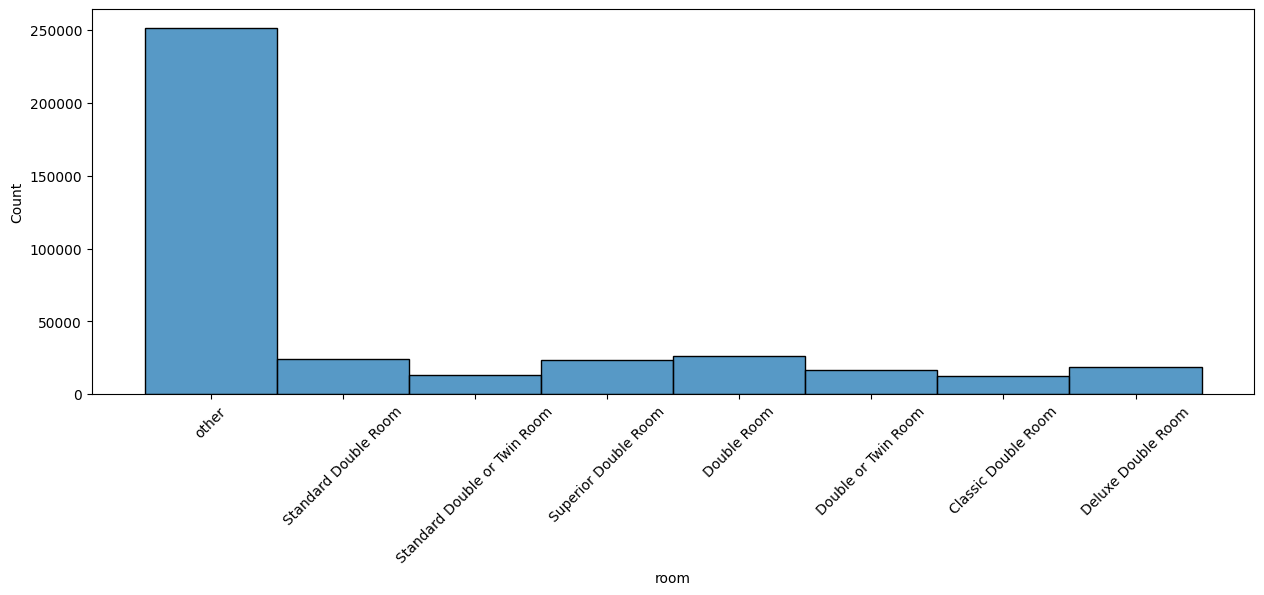

In [77]:
def room (list):
    for i in list:
        if i in list_teg_larg:
            return i
    #Если не встретилось ни одно значение, то возвращаем other
    return 'other'

#В изначальном списке тегов остались только теги с типами комнат используем его для преобразования данных
data['room'] = data['tags'].apply(room)

#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.histplot (x='room', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

На графике видно, что в категории other попало слишком много значений. Попробуем другие методы обработки этих данных.

'Пропущенных значений = 0.0'

{'web': 'https://www.comet.com/api/image/download?imageId=0f9f3da49b614600a2d4bbbcb72fbb69&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0f9f3da49b614600a2d4bbbcb72fbb69&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '0f9f3da49b614600a2d4bbbcb72fbb69'}

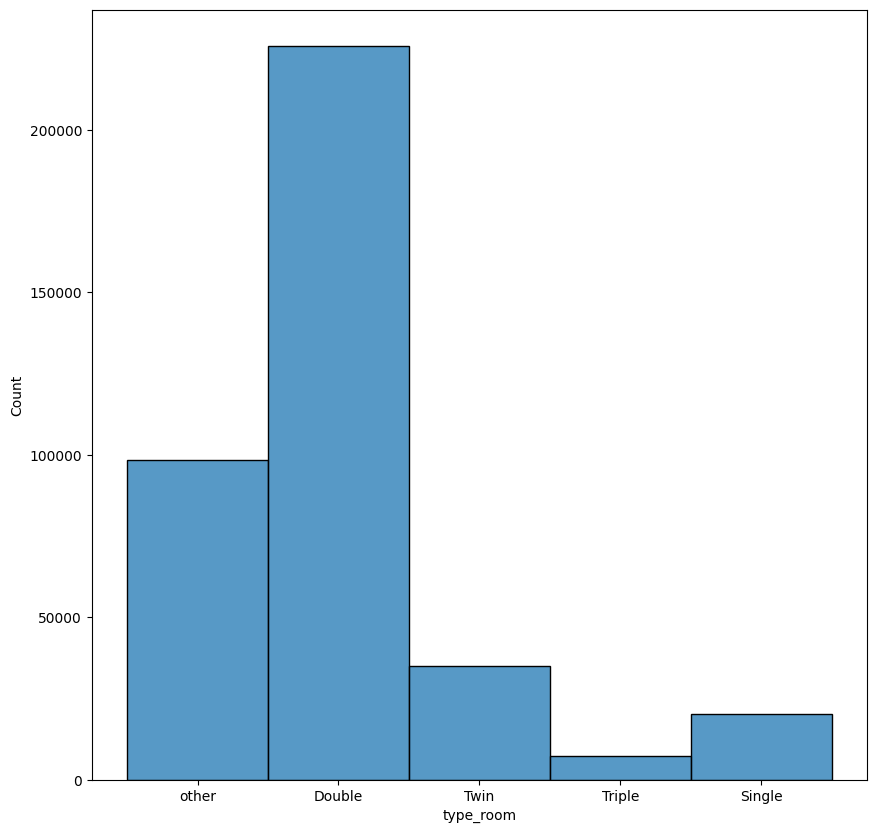

In [78]:
#Пробуем разделить комнаты по типу размещения
def type_room (list):
    for i in list:
        if ('Single' in i): return 'Single'
        elif ('Double' in i): return 'Double'
        elif ('Twin' in i ): return 'Twin'
        elif ('Triple' in i ): return 'Triple'
        #если попадается значение не встречающееся в списке, то это зачастую большее количество ночей. Для таких строк мы присвоим значение 4
    return 'other'

#определим список с наиболее встречающимися значениями количества ночей
dict_room = {'Single':1, 'Double':2, 'Twin':2, 'Triple': 3}
data['type_room'] =  data['tags'].apply(type_room)

#Проверим полученные результаты
display(f"Пропущенных значений = {data['type_room'].isnull().mean() * 100}")

#визуализируем полученные данные
ax = sns.histplot(x='type_room', data=data);

experiment.log_figure(figure=plt)

Такое распределение данныз подходит лучше. Удалим предыдущий признак и признак *tags* так как остальные его знаечния слишком мелкие для преобразований

In [79]:
drop_list = ['room','tags']
data.drop(drop_list, axis = 1, inplace=True)

## Признак hotel_address

Преобразуем адрес. Для этого выделим страну и город. Проанализируем 20 наиболее часто встречающихся адресов.

In [80]:
display (f"Всего уникальных адресов: {len(data.hotel_address.value_counts())}")
display (data.hotel_address.value_counts().nlargest(20))

'Всего уникальных адресов: 1493'

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              2218
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  2097
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 1982
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        1939
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      1889
27 Devonshire Terrace Westminster Borough London W2 3DP United Kingdom            1737
Lakeside Way Brent London HA9 0BU United Ki

По данным видно, что город и страна обычно 2 последних слова в адресе. Но если страна United Kingdom, то город будет 5 словом с конца. Напишем функцию, которая выберет эти значения из адреса.

{'web': 'https://www.comet.com/api/image/download?imageId=cc4af6eafb07435c94356b56a422c7eb&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=cc4af6eafb07435c94356b56a422c7eb&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'cc4af6eafb07435c94356b56a422c7eb'}

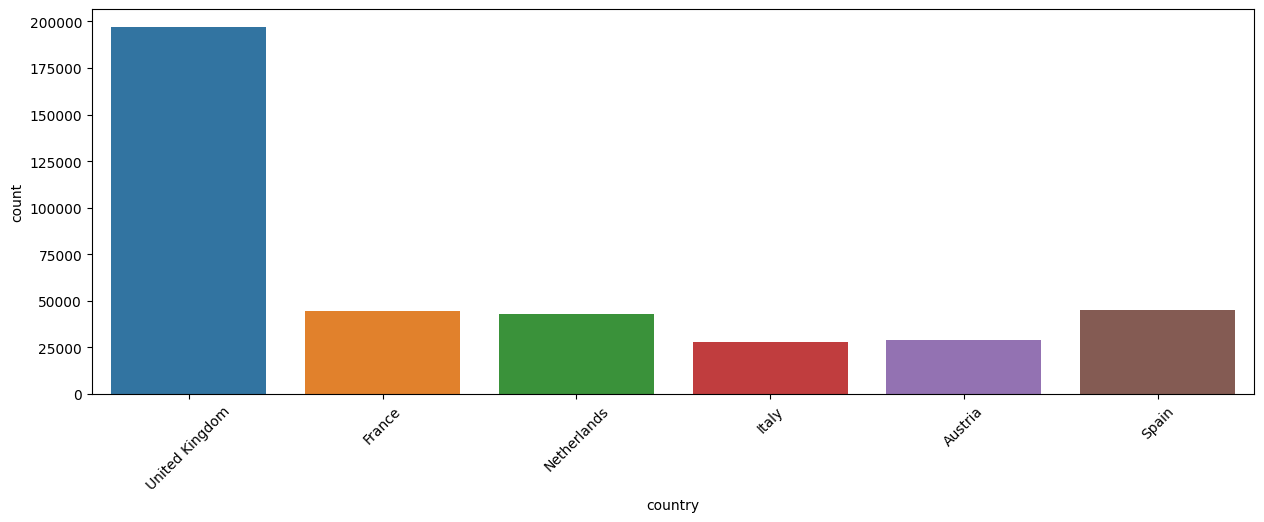

In [81]:
def country (adress):
    list_adress = adress.split()
    list_adress.reverse()
    country = ''
    if list_adress [0] == 'Kingdom':
        country = 'United Kingdom'
    else:
        country = list_adress [0]
    return country


data['country'] = data['hotel_address'].apply(country)


#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='country', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

{'web': 'https://www.comet.com/api/image/download?imageId=9802a75a71b0402fab0b20aa352248f3&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=9802a75a71b0402fab0b20aa352248f3&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '9802a75a71b0402fab0b20aa352248f3'}

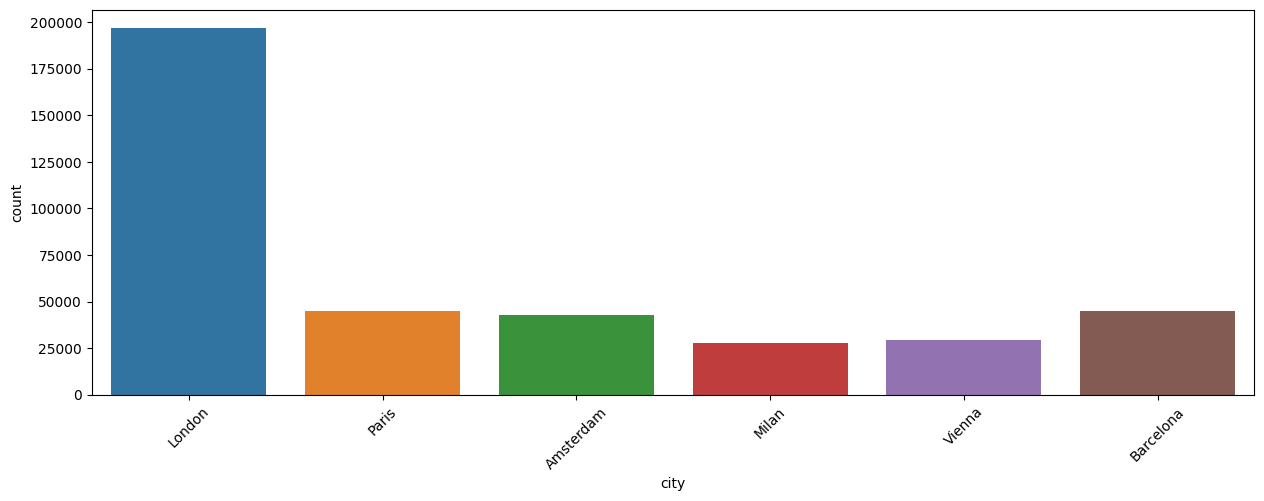

In [82]:
def city (adress):
    list_adress = adress.split()
    list_adress.reverse()
    city = ''
    if list_adress [0] == 'Kingdom':
        city = list_adress [4]
    else:
        city = list_adress [1]   
    return city

data['city'] =  data['hotel_address'].apply(city)

#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='city', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

По полученным данным видно, что они собраны по 1 городу в каждой стране, поэтому нет смысла оставлять оба параметра. Удалим признак *country*. Признак *hotel_address* тоже больше не нужен

In [83]:
drop_list = ['country']
data.drop(drop_list, axis = 1, inplace=True)

## Признак reviewer_nationality

Посмотрим признак reviewer_nationality. Выведем 20 наиболее часто встречающихся значений

In [84]:
display(data.reviewer_nationality.value_counts().nlargest(20))

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
 Saudi Arabia                   6722
 Netherlands                    6608
 Switzerland                    6498
 Canada                         5984
 Germany                        5956
 France                         5543
 Israel                         4918
 Italy                          4562
 Belgium                        4529
 Turkey                         4105
 Kuwait                         3702
 Spain                          3529
 Romania                        3425
 Russia                         2953
 South Africa                   2888
Name: reviewer_nationality, dtype: int64

Так как значений очень много, попробуем объеденить их в части света. Для этого спарсим данные о том, какая страна к какому региону принадлежит и составим словарь

In [85]:
import requests # Импортируем библиотеку requests
from bs4 import BeautifulSoup # Импортируем библиотеку BeautifulSoup

url = 'https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification' # Определяем адрес страницы

response = requests.get(url)  # Выполняем GET-запрос

print(response)  # Выводим содержимое атрибута text

<Response [200]>


In [86]:
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер

links = page.find_all('td') # Ищем все ссылки на странице и сохраняем в переменной links в виде списка

list_region = [link.text.strip() for link in links[::3]]
list_country = [link.text.strip() for link in links[1::3]]

df_region = pd.DataFrame(list_country, list_region)

display(df_region.head())

,0
Andorra,Europe
United Arab Emirates,Middle east
Afghanistan,Asia & Pacific
Antigua and Barbuda,South/Latin America
Anguilla,South/Latin America


{'web': 'https://www.comet.com/api/image/download?imageId=40a9e0ee8bf5407c8934eb5152006823&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=40a9e0ee8bf5407c8934eb5152006823&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '40a9e0ee8bf5407c8934eb5152006823'}

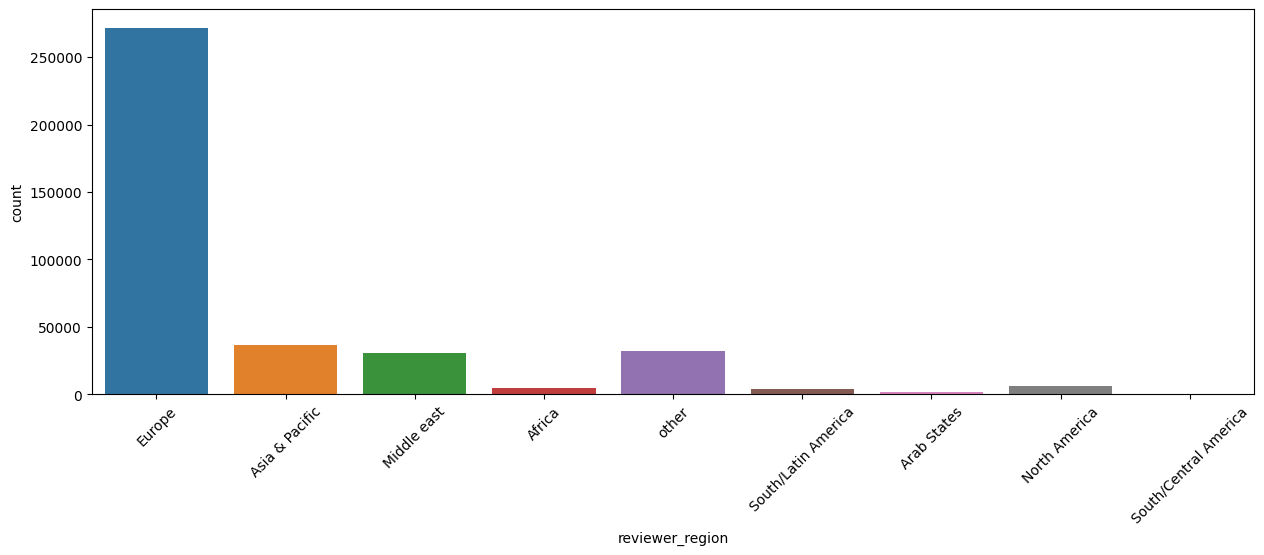

In [87]:
def counrty_region (str):
    if str.strip() in df_region.index:
        return df_region.loc[str.strip()][0]
    else:
        return 'other'

data['reviewer_region']=data['reviewer_nationality'].apply(counrty_region) 

#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='reviewer_region', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

In [88]:
#Проверим какие данные попали в категорию 'other'
data[data['reviewer_region']=='other']['reviewer_nationality'].value_counts()

 United States of America             26541
 Russia                                2953
 Iran                                   830
 South Korea                            802
                                        395
 Abkhazia Georgia                       116
 Moldova                                 86
 Brunei                                  78
 Kosovo                                  51
 Tanzania                                43
 Cura ao                                 29
 Syria                                   23
 Ivory Coast                             15
 Antigua Barbuda                         12
 British Virgin Islands                  12
 Turks Caicos Islands                    12
 U S Virgin Islands                      11
 Swaziland                                7
 Laos                                     6
 St Maarten                               6
 Democratic Republic of the Congo         6
 Falkland Islands Malvinas                5
 Crimea                         

Мы видим, что в категорию 'other' попали 'United States of America', 'Russia', 'Iran' и 'South Korea' перераспредилим их в соответсвующие категории. Остальных значений мало, поэтмоу они не сильно повлияют на данные и мы остаивм их в категории 'other'. Так же объеденим все разновидности 'America' в одну категорию, а азиатские, арабские страны и страны среднего востока, объединим в Азию.

{'web': 'https://www.comet.com/api/image/download?imageId=3f8e5e93a7424c4cbe6b2b7c5f659f24&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3f8e5e93a7424c4cbe6b2b7c5f659f24&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '3f8e5e93a7424c4cbe6b2b7c5f659f24'}

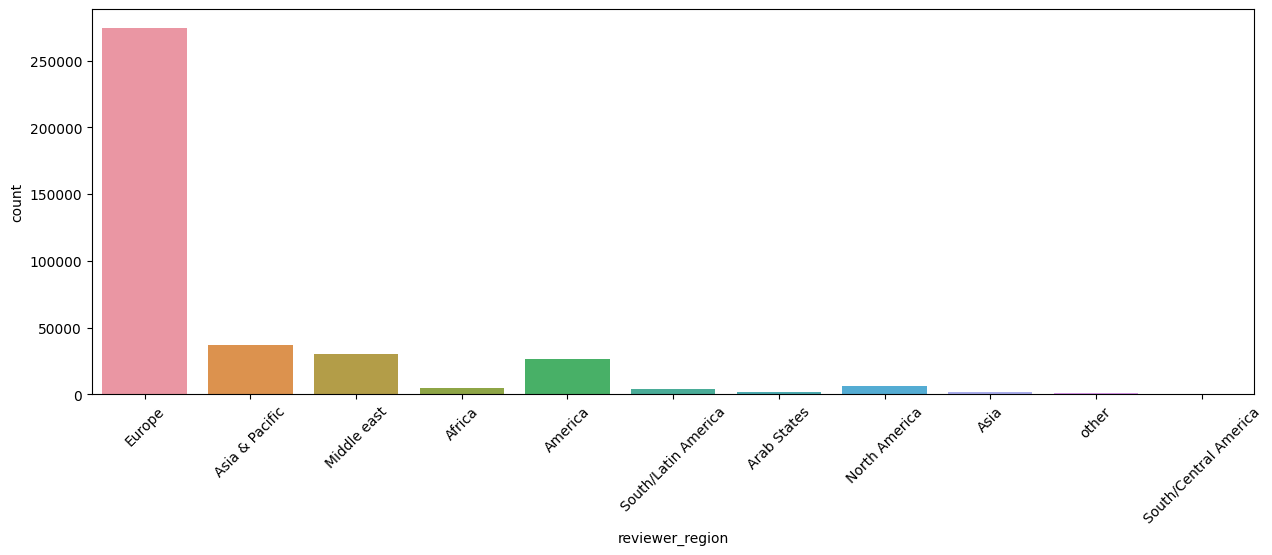

In [89]:
#Зададим словарь соответсвий
dict_country = {'United States of America':'America', 'Russia': 'Europe', 'Iran':'Asia', 'South Korea':'Asia'}
#И немного поправим функцию преобразования значений
def counrty_region_new (str):
    if str.strip() in dict_country.keys():
        return dict_country [str.strip()]
    elif str.strip() in df_region.index:
        return df_region.loc[str.strip()][0]
    else:
        return 'other'

data['reviewer_region']=data['reviewer_nationality'].apply(counrty_region_new) 

#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='reviewer_region', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

{'web': 'https://www.comet.com/api/image/download?imageId=a1792a0e5641478ea385ea2e12765d22&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a1792a0e5641478ea385ea2e12765d22&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'a1792a0e5641478ea385ea2e12765d22'}

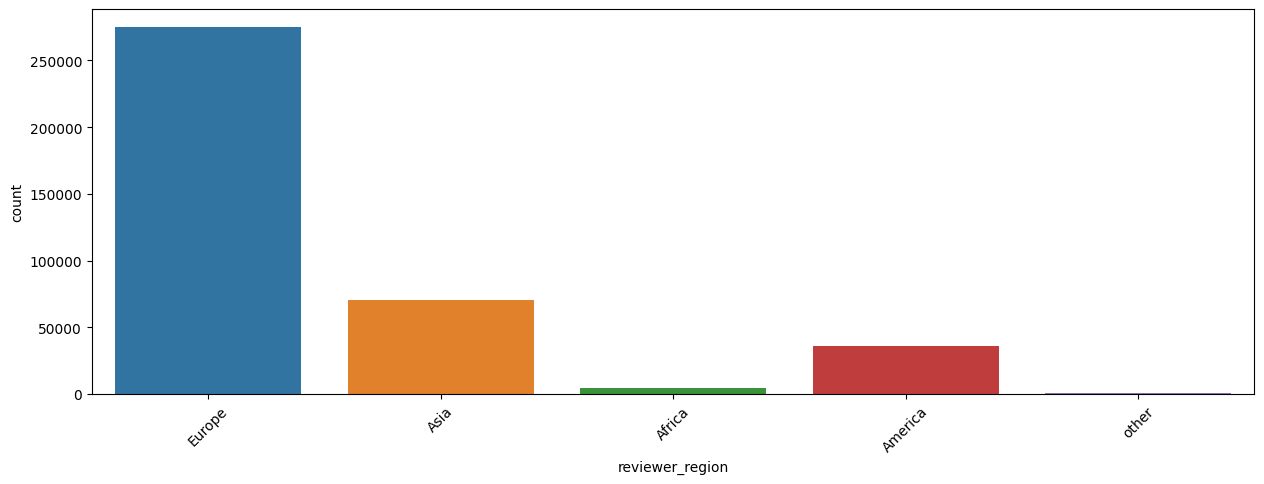

In [90]:
#Объеденим все данные по Америке в одну группу. А Австралию объеденим с Океанией, а Asia, Europe присоеденим к Asia
data['reviewer_region']= data['reviewer_region'].apply(lambda x: 'America' if 'America' in x else x)
data['reviewer_region']= data['reviewer_region'].apply(lambda x: 'Asia' if 'Middle east' in x else x)
data['reviewer_region']= data['reviewer_region'].apply(lambda x: 'Asia' if 'Arab States' in x else x)
data['reviewer_region']= data['reviewer_region'].apply(lambda x: 'Asia' if 'Asia' in x else x)

plt.figure(figsize = (15,5))
ax = sns.countplot(x='reviewer_region', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

In [91]:
#признак reviewer_nationality больше не нужен, можно удалить
drop_list = ['reviewer_nationality']
data.drop(drop_list, axis = 1, inplace=True)

## Признак total_number_of_reviews_reviewer_has_given

Перейдём к признаку total_number_of_reviews_reviewer_has_given. Он указывает, столько отзывов раньше оставлял пользователь. Посмотрим распределение признака

{'web': 'https://www.comet.com/api/image/download?imageId=c30ed54806244f39bff2da6321644583&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c30ed54806244f39bff2da6321644583&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'c30ed54806244f39bff2da6321644583'}

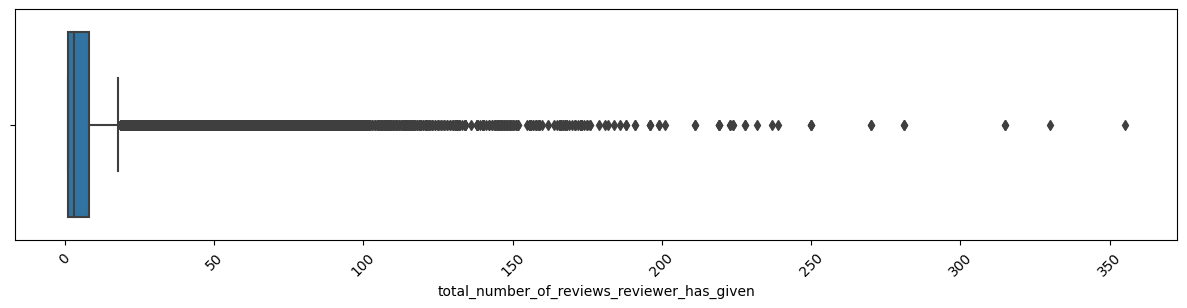

In [92]:
plt.figure(figsize = (15,3))
ax = sns.boxplot(x=data['total_number_of_reviews_reviewer_has_given']);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

На графике видно, что чаще всего у пользователей меньше 10 отзывов, но есть и те, у кого более 200 отзывов. Пользователей, у кого всего 1 оставленный отзыв мы пометим как "сомнительные". Пользователей, у кого больше 10 отзывов, мы пометим как проверенные. 

In [93]:
data ['questionable review'] = data["total_number_of_reviews_reviewer_has_given"].apply(lambda x: 1 if x == 1 else 0)
data ['verified review'] = data["total_number_of_reviews_reviewer_has_given"].apply(lambda x: 1 if x > 10 else 0)

## Признаки review_date и days_since_review

У нас есть два признака, связанных с датой. Это review_date и days_since_review. Первый переведём в DataTime и выделим год написания отзыва. У второго выделим число, отбросив слово *days*

{'web': 'https://www.comet.com/api/image/download?imageId=fb72e1d60a08409db62c21b644ae5574&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=fb72e1d60a08409db62c21b644ae5574&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'fb72e1d60a08409db62c21b644ae5574'}

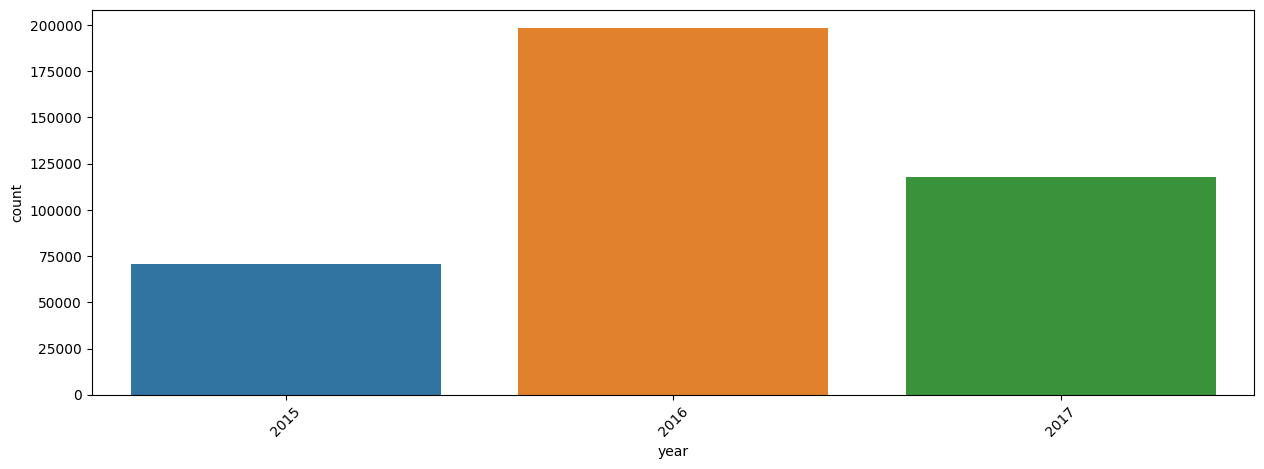

In [94]:
#сначала разберёмся с годом
data ['review_date'] = pd.to_datetime(data['review_date'])
data ['year'] = data ['review_date'].dt.year

#проверим полученные данные 
plt.figure(figsize = (15,5))
ax = sns.countplot(x='year', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

In [95]:
#признак reviewer_nationality больше не нужен, можно удалить
drop_list = ['review_date']
data.drop(drop_list, axis = 1, inplace=True)

## Признак days_since_review

In [96]:
#теперь выделим день и преобразуем его в число
data ['days_since_review'] = data ['days_since_review'].apply(lambda x: int(x.split()[0]))

## Признаки review_total_negative_word_counts и review_total_positive_word_counts

При визуальном анализе данных я обратила внимание, что количество слов в негативном отзыве не совпадает с признаком review_total_negative_word_counts. К тому же, в отзыве встречаются слова Nothing, посчитанные как негативные. Попробуем пересчитать слова в отзывах.

In [97]:
def count_words (words):
    if ('Nothing' in words) or ('No Negative' in words) or ('No Positive' in words): 
        return 0
    else:
        return (len(words.split())) 

data['negative_word_counts'] = data['negative_review'].apply(count_words)
data['positive_word_counts'] = data['positive_review'].apply(count_words)
        
data.head(10)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,residents,night,type_room,city,reviewer_region,questionable review,verified review,year,negative_word_counts,positive_word_counts
0,Stratton Street Mayfair Westminster Borough Lo...,581,8.4,The May Fair Hotel,Leaving,3,1994,Staff were amazing,4,7,...,Couple,2,other,London,Europe,0,0,2016,1,3
1,130 134 Southampton Row Camden London WC1B 5AF...,299,8.3,Mercure London Bloomsbury Hotel,poor breakfast,3,1361,location,2,14,...,Couple,1,Double,London,Europe,0,1,2017,2,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,8.9,Legend Saint Germain by Elegancia,No kettle in room,6,406,No Positive,0,14,...,Solo traveler,3,Double,Paris,Asia,0,1,2016,4,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,7.5,Mercure Paris 19 Philharmonie La Villette,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,...,Solo traveler,1,Double,Paris,Europe,0,0,2015,0,9
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,8.5,Golden Tulip Amsterdam West,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,...,Couple,6,Double,Amsterdam,Europe,0,0,2016,2,18
5,Via Mecenate 121 20138 Milan Italy,105,8.0,Novotel Milano Linate Aeroporto,Nothing,2,1607,Very nice hotel Price is excellent when compa...,16,1,...,Solo traveler,1,Twin,Milan,Europe,1,0,2015,0,14
6,97 Cromwell Road Kensington and Chelsea London...,854,7.8,Holiday Inn London Kensington Forum,Nothing it was lovely,6,3867,Very central location 2 minutes walk from Glo...,29,4,...,Couple,1,Double,London,Europe,0,0,2017,0,27
7,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,8.3,Mercure Josefshof Wien,The communal areas are a bit soul less and th...,40,2526,The location is good for transport links espe...,107,39,...,Couple,4,Double,Vienna,Europe,0,1,2017,38,105
8,190 Queen s Gate Kensington and Chelsea London...,227,8.6,The Gore Hotel Starhotels Collezione,undergoing refurbishment no tea coffer in roo...,30,968,staff very good location wonderful,7,3,...,Couple,1,Double,London,Europe,0,0,2015,29,5
9,Holland Park Avenue Kensington and Chelsea Lon...,843,7.8,Hilton London Kensington Hotel,I advised it was for my husbands birthday and...,47,3801,No Positive,0,1,...,Couple,1,Twin,London,Europe,1,0,2016,45,0


In [98]:
#признак reviewer_nationality больше не нужен, можно удалить
drop_list = ['review_total_negative_word_counts','review_total_positive_word_counts']
data.drop(drop_list, axis = 1, inplace=True)

In [99]:
def link_page (url):
    list_links, list_eng_total, list_rus_total = [],[],[]
    response1 = requests.get(url)  # Выполняем GET-запрос
    print(response1)  # Выводим содержимое атрибута text
    page = BeautifulSoup(response1.text, 'html.parser') # Создаём объект BeautifulSoup, указывая html-парсер
    links = page.find_all('tr') # Ищем все ссылки на странице и сохраняем в переменной links в виде списка
    list_links = [link.text for link in links[::1]]
    for i in list_links:
        if i != list_links[0]:
            list_i = i.split('\n')
            list_eng_total.append(list_i[0].lower())
            list_rus_total.append(list_i[1].lower())
    return list_eng_total, list_rus_total

In [100]:
url_bad = 'https://www.englishdom.com/blog/vse-sinonimy-slova-bad-negativnye-prilagatelnye-v-anglijskom/' # Определяем адрес страницы
bad_eng, bad_rus = link_page (url_bad) 
df_bad = pd.DataFrame(bad_rus,  bad_eng)

<Response [200]>


In [101]:
url_good = 'https://www.englishdom.com/blog/vse-sinonimy-slova-good/' # Определяем адрес страницы
good_eng, good_rus = link_page (url_good) 
df_good = pd.DataFrame(good_rus,  good_eng)

<Response [200]>


In [102]:
def count_words_in_rewiew (str,df):    
    list_words = str.split()
    count = 0
    for word in list_words:
        if word.strip() in df.index:
            count+=1
    return count

data['good_words'] = 0
data['bed_words'] = 0

for i in range(data.shape[0]):
    data['good_words'][i]= count_words_in_rewiew ( data['positive_review'][i],df_good) 
    data['bed_words'][i]= count_words_in_rewiew ( data['negative_review'][i],df_bad)

C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\1067491353.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['good_words'][i]= count_words_in_rewiew ( data['positive_review'][i],df_good)
C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\1067491353.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bed_words'][i]= count_words_in_rewiew ( data['negative_review'][i],df_bad)


{'web': 'https://www.comet.com/api/image/download?imageId=bed57d5f83364171a6ac56048f22c76a&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=bed57d5f83364171a6ac56048f22c76a&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'bed57d5f83364171a6ac56048f22c76a'}

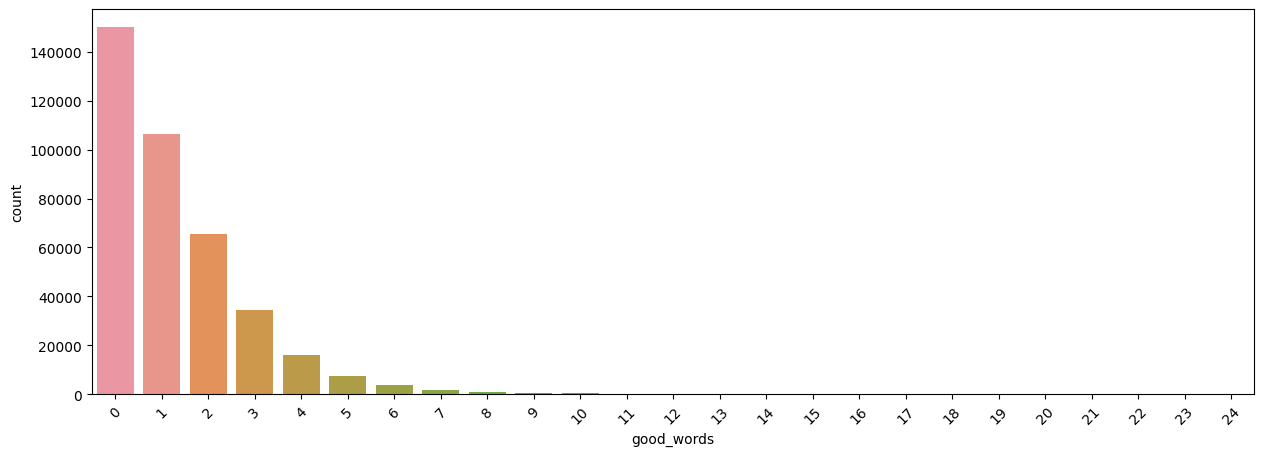

In [103]:
#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='good_words', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

{'web': 'https://www.comet.com/api/image/download?imageId=0d9bdc1b8f744ffb84753b0ef8d674db&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=0d9bdc1b8f744ffb84753b0ef8d674db&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '0d9bdc1b8f744ffb84753b0ef8d674db'}

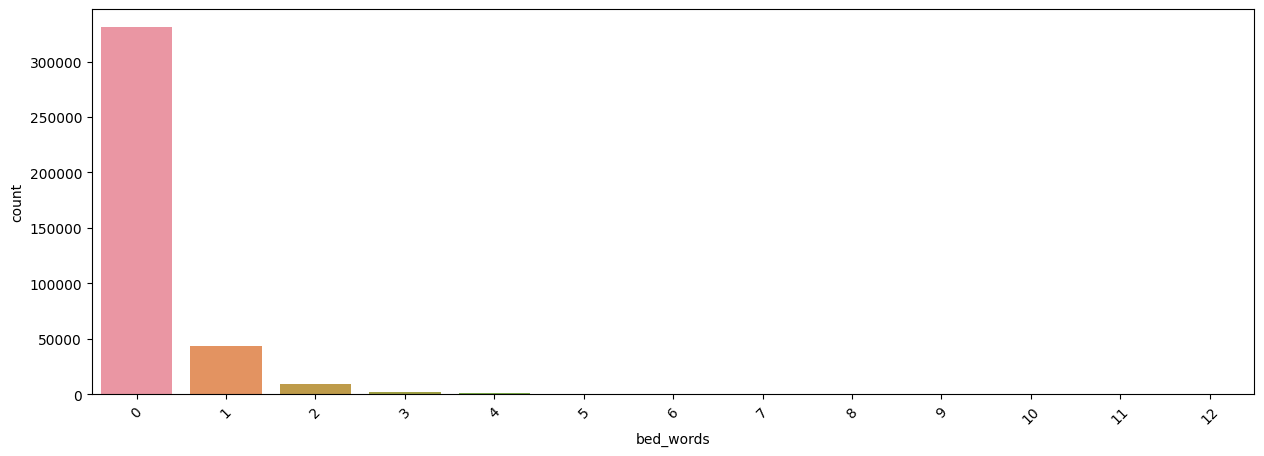

In [104]:
#визуализируем полученные данные
plt.figure(figsize = (15,5))
ax = sns.countplot(x='bed_words', data=data);
plt.xticks(rotation=45);

experiment.log_figure(figure=plt)

## Признаки additional_number_of_scoring и total_number_of_reviews

Теперь посмотрим на признаки *additional_number_of_scoring*, котоырй показывает сколько проставленно оценок без отзывов, и *total_number_of_reviews*, показывающий сколько всего проставленно оценок отелю. Посмотрим, есть ли отели, у которых количество оценок без отзывов больше 25% от общего числа оценок.

In [105]:
mask = data['additional_number_of_scoring'] > data['total_number_of_reviews']*0.30
count_number = data[mask]['hotel_name'].value_counts()
display (f'Количество отелей, у которых количество оценок без отзывов больше 30% от общего числа оценок: {count_number.shape[0]}')

'Количество отелей, у которых количество оценок без отзывов больше 30% от общего числа оценок: 63'

In [106]:
#создадим признак, в котормо пометим эти отели как сомнительные
data['questionable_hotel'] = data ['hotel_name'].apply(lambda x: 1 if x in list(count_number.index) else 0)
display(data['questionable_hotel'].value_counts())

0    361740
1     25063
Name: questionable_hotel, dtype: int64

## Признаки lat и loc

Перейдём к признакам широты и долготы. Данные признаки содержат пропуски. Определим в каких городах находятся отели, имеющие пропуски.

In [107]:
data_loc = list(data[data['lat'].isnull()]['hotel_address'].unique())
display (data_loc)

['Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 '20 Rue De La Ga t 14th arr 75014 Paris France',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria']

In [108]:
from geopy.geocoders import Nominatim

dic_lat, dic_lng = {}, {}

for i in data_loc:
    list_i = i.split()
    list_i.reverse()
    str_address=''
    for j in range(len(list_i)):
        if j < 3: 
            str_address = list_i[j] + ' ' +str_address
    geolocator = Nominatim(user_agent="your_app_name")
    location = geolocator.geocode(str_address)
    dic_lat [i] = location.latitude
    dic_lng [i] = location.longitude

In [109]:
data['city'].value_counts().index

Index(['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan'], dtype='object')

In [110]:
from geopy.geocoders import Nominatim

dic_lat_enter_city, dic_lng_enter_city = {}, {}

cityes = data['city'].value_counts().index

for city in cityes:
    geolocator = Nominatim(user_agent="tester")
    location = geolocator.geocode(city)
    dic_lat_enter_city [city] = location.latitude
    dic_lng_enter_city [city] = location.longitude

In [111]:
dic_lat_enter_city

{'London': 51.5073359,
 'Barcelona': 41.3828939,
 'Paris': 48.8534951,
 'Amsterdam': 52.3730796,
 'Vienna': 48.2083537,
 'Milan': 45.4641943}

In [112]:
dic_lng_enter_city

{'London': -0.12765,
 'Barcelona': 2.1774322,
 'Paris': 2.3483915,
 'Amsterdam': 4.8924534,
 'Vienna': 16.3725042,
 'Milan': 9.1896346}

In [113]:
for i in range(data.shape[0]):
    if data['hotel_address'][i] in dic_lat.keys():
        data['lat'][i] = dic_lat[data['hotel_address'][i]]
        data['lng'][i] = dic_lng[data['hotel_address'][i]]

C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\3226479818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lat'][i] = dic_lat[data['hotel_address'][i]]
C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\3226479818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lng'][i] = dic_lng[data['hotel_address'][i]]


C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\1682254997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data ['distance'][i] = distance_between_points (a_lat, a_lng, city_a)


{'web': 'https://www.comet.com/api/image/download?imageId=668475402704488d9f0152b2dee8e400&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=668475402704488d9f0152b2dee8e400&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '668475402704488d9f0152b2dee8e400'}

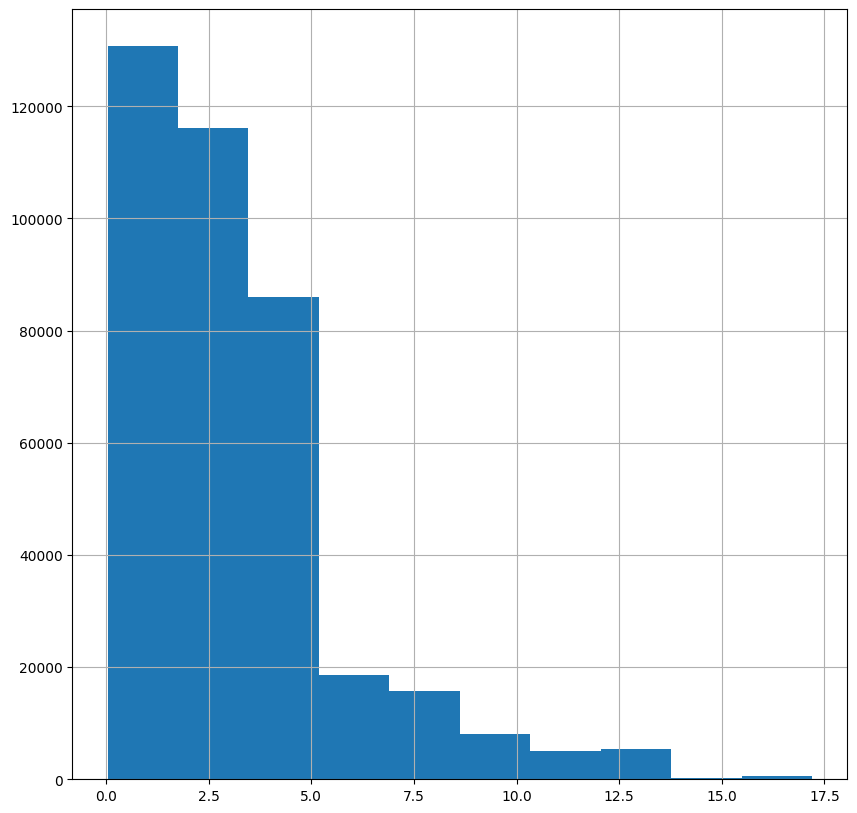

In [114]:
from geopy.distance import geodesic as GD 

def distance_between_points (a_lat, a_lng, city):
    point_a = (a_lat, a_lng)
    point_b = (dic_lat_enter_city [city], dic_lng_enter_city [city])
    return GD(point_a, point_b).km


data ['distance']=0
for i in range(data.shape[0]):
    a_lat = data['lat'][i]
    a_lng = data['lng'][i]
    city_a = data['city'][i]
    data ['distance'][i] = distance_between_points (a_lat, a_lng, city_a)
    
data ['distance'].hist()

experiment.log_figure(figure=plt)

In [115]:
#признаки lat, lng и hotel_address можно удалить
drop_list = ['lat', 'lng', 'hotel_address']
data.drop(drop_list, axis = 1, inplace=True)

## Построение модели

C:\Users\LesenaM\AppData\Local\Temp\ipykernel_3040\2256600132.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True);


{'web': 'https://www.comet.com/api/image/download?imageId=3f168b3760004f019704bf119a50cadd&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3f168b3760004f019704bf119a50cadd&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': '3f168b3760004f019704bf119a50cadd'}

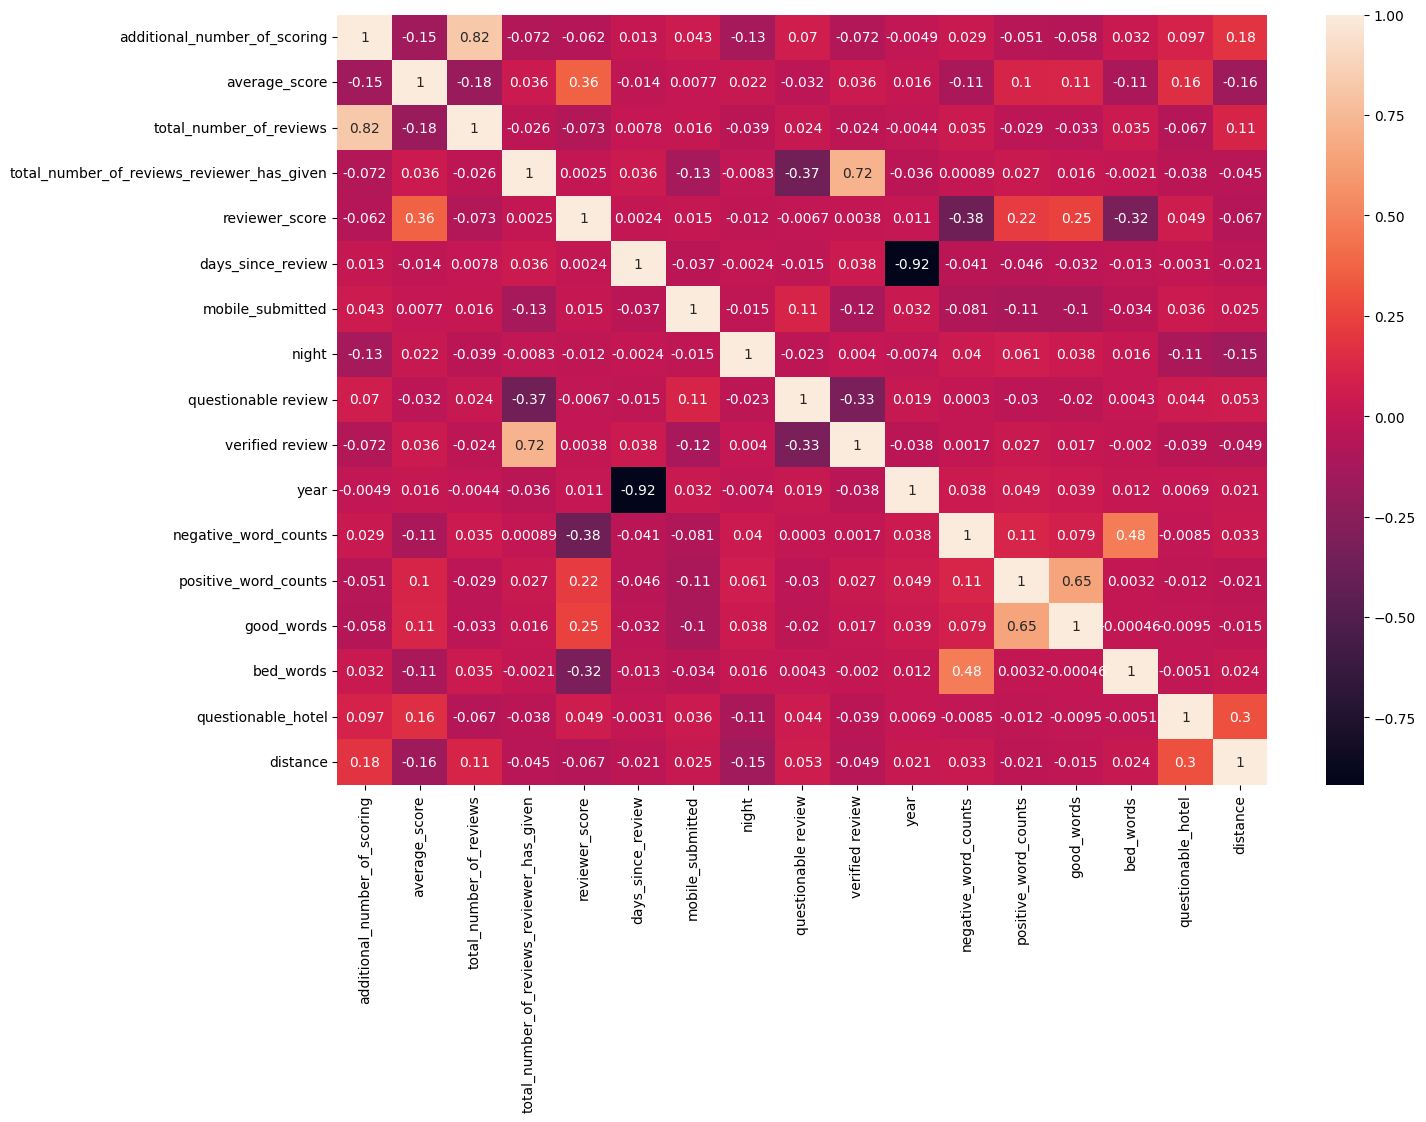

In [116]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), annot=True);

experiment.log_figure(figure=plt)

In [117]:
# все новые значения кодируем с помощью OneHotEncoder
encoder_list = ['residents','type_of_trip','type_room','city','reviewer_region']
for i in encoder_list:
    encoder = ce.OneHotEncoder(cols=i, use_cat_names=True) 
    type_bin = encoder.fit_transform(data[i])
    data = pd.concat([data, type_bin], axis=1)

In [118]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [119]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']

In [120]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [121]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [122]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [123]:
params={"random_state":RANDOM_SEED,
        "model_type":"RandomForestRegressor"
}
experiment.log_parameters(params)

{'web': 'https://www.comet.com/api/image/download?imageId=c5b195d3358947ea9bb9fc810664cc80&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=c5b195d3358947ea9bb9fc810664cc80&experimentKey=ab106ac3c6e14d93b11748a0ba429698',
 'imageId': 'c5b195d3358947ea9bb9fc810664cc80'}

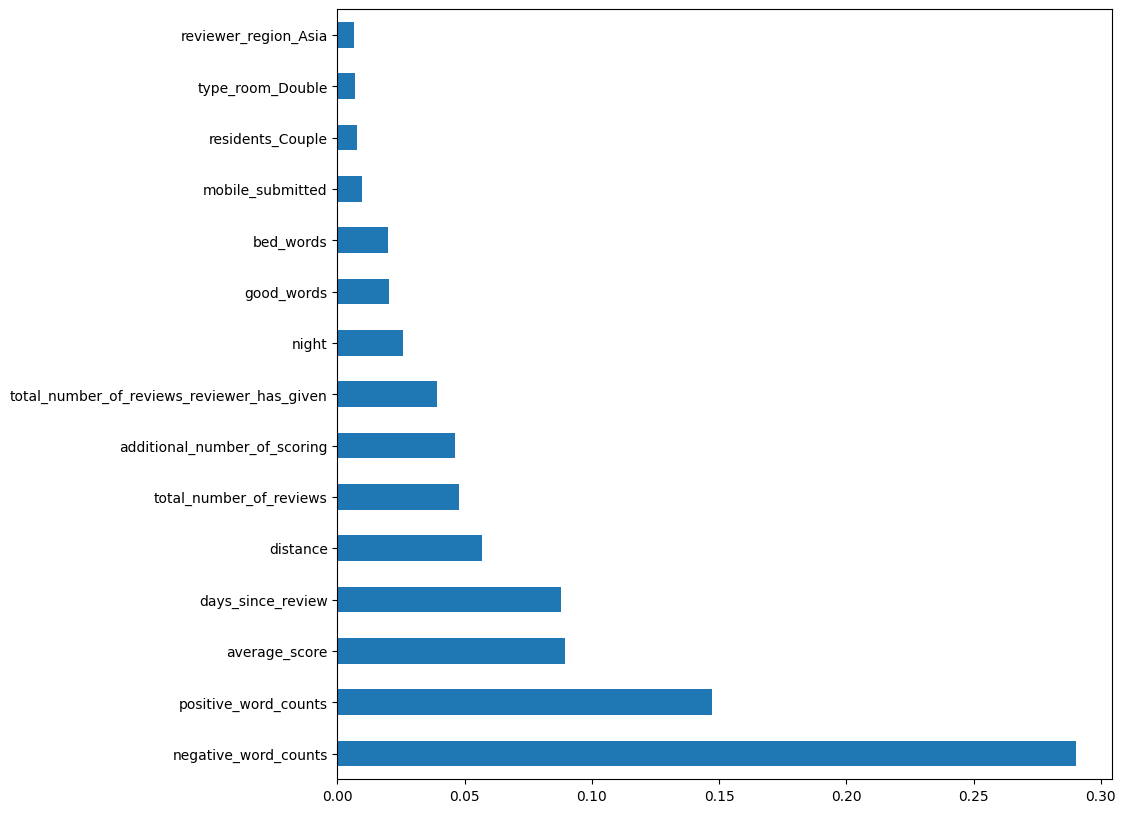

In [124]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

experiment.log_figure(figure=plt)

In [125]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
metric = {'MAPE' : metrics.mean_absolute_percentage_error(y_test, y_pred)}
print(metric)

experiment.log_metrics(metric, step=20)

{'MAPE': 0.1325401573780853}


In [126]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/olesyanori/eda-3/ab106ac3c6e14d93b11748a0ba429698
COMET INFO:   Metrics:
COMET INFO:     MAPE : 0.1325401573780853
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     criterion                : squared_error
COMET INFO:     max_depth                : 1
COMET INFO:     max_features             : 1.0
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_weig